In [1]:
%load_ext autoreload
%autoreload 2

# Load Dependencies
import matplotlib.pyplot as plt

import torch

import pyro
import numpy as np
import pyro.distributions as dist

from pyciemss.ODE.askem_primitives import sample, infer_parameters, intervene, optimization
from pyciemss.ODE.base import ODE, Time, State, Solution, Observation
from typing import Dict, Optional

from pyciemss.utils import get_tspan

/Users/sam-basis/opt/anaconda3/envs/sw-demo-primitives/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [81]:
# Plotting Utilities

def setup_ax(ax=None):

    if not ax:
        fig = plt.figure(facecolor='w', figsize=(9, 9))
        ax = fig.add_subplot(111, axisbelow=True)

    ax.set_ylim(0, 1.1)
    ax.set_ylabel('Proportion of Individuals')
    return ax

def plot_predictive(prediction, tspan, plot_var, plot_index=None, tmin=None, ax=None, alpha=0.2, color="black", **kwargs):


    if plot_index is not None:
        low = torch.quantile(prediction[plot_var][:, :, 0, plot_index], 0.05, dim=0).detach().numpy()
        up = torch.quantile(prediction[plot_var][:, :, 0, plot_index], 0.95, dim=0).detach().numpy()
    else:
        low = torch.quantile(prediction[plot_var], 0.05, dim=0).detach().numpy()
        up = torch.quantile(prediction[plot_var], 0.95, dim=0).detach().numpy()        

    if tmin:
        indeces = tspan >= tmin
    else:
        indeces = torch.ones_like(tspan).bool()

    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
    
    ax.fill_between(tspan[indeces], low[indeces], up[indeces], alpha=alpha, color=color, **kwargs)

    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    ax.set_xlabel('Time /days')

    return ax

def plot_trajectory(data, tspan, plot_var, plot_index=None, ax=None, color='black', alpha=0.5, lw=0, marker='.', label=None):
    # Plot the data on three separate curves for S(t), I(t) and R(t)

    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

    if plot_index is not None:
        result = data[plot_var][:, :, 0, plot_index].squeeze().detach().numpy()
    else:
        result = data[plot_var].squeeze().detach().numpy()


    ax.plot(tspan, result, color, alpha=alpha, lw=lw, marker=marker, label=label)
    ax.set_xlabel('Time /days')
    
    return ax

def plot_intervention_line(t, ax=None):
    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

    ylim = ax.get_ylim()

    ax.vlines(t, min(ylim), max(ylim), color="grey", ls='-')

    return ax

# **Overview** 

## In this notebook we use pyciemss, an early prototype of the CIEMSS team's probabilistic programming software for simulation modeling, to answer a number of questions related to epidemiological analysis using a stratified SIR model. 

To emphasize our team's probabilistic reasoning capabilities, we have elaborated on the scenario questions to include uncertainty in model parameters.

To emphasize our team's causal reasoning capabilities, we have elaborated on the scenario questions to include more complicated interventions. Specifically, we explore interventions that can not simply be represented as a change in parameters, instead requiring manipulation of the simulation runtime.



## Model

The following model implements the stratified SIR scenario for all of the scenario questions. Note, that the model is defined over tensors of stratified $S$, $I$, and $R$ variables, where each element represents a different stratum. This means that the same model applies regardless of the number of stratum.

In [73]:
from pyro.nn import pyro_method

from pyciemss.ODE.base import ODE, Time, State, Solution, Observation
from pyciemss.utils import state_flux_constraint

class StratifiedSIR(ODE):
    def __init__(self,
                C_prior,
                Ro_prior,
                gamma_prior
                ):
        super().__init__()

        self.C_prior = C_prior
        self.Ro_prior = Ro_prior
        self.gamma_prior = gamma_prior

    @pyro_method
    def deriv(self, t: Time, state: State) -> State:
        '''
        This method defines the derivative of `state` as a function of `state` and `t`.
        '''
        
        S, I, R = state
        
        SI_flux = state_flux_constraint(S, pyro.deterministic("SI_flux %f" % (t), (torch.transpose(S, 0, 1) * I) * self.C * self.Ro).sum(axis=1))

        IR_flux = state_flux_constraint(I, pyro.deterministic("IR_flux %f" % (t), I * self.gamma))

        dSdt = -SI_flux
        dIdt = SI_flux - IR_flux
        dRdt = IR_flux

        return dSdt, dIdt, dRdt

    @pyro_method
    def param_prior(self) -> None:
        '''
        This method samples each parameter from its corresponding prior.
        '''

        self.C = pyro.sample("C", self.C_prior)
        self.Ro = pyro.sample("Ro", self.Ro_prior)
        self.gamma = pyro.sample("gamma", self.gamma_prior)

    @pyro_method
    def observation_model(self, solution: Solution, data: Optional[Dict[str, State]] = None) -> Solution:
        '''
        This method defines how observations probabilistically relate to the true state trajectory over time.
        This is also sometimes called a "noise model".
        '''
        names = ["S", "I", "R"]

        solution = tuple(torch.where(s > 0, s, 0) for s in solution)
        # Add no noise to the observation, as we're not conditioning on any data and don't need to use this for inference.
        return [pyro.deterministic(names[i], solution[i]) for i in range(len(names))]

# **Question 1.** 

**Subtask A** - Stratify by young, middle, and old age and simulate with many configurations.

First, we set up all of the initial conditions and priors that are persistent across a.i, a.ii, etc.

Note that as we are applying a probabilistic approach, we interpret every statement of the form "assume the parameters are x" to mean "assume the prior over parameters are centered at x, with some user-specified distribution". 

In [142]:
# INITIAL CONDITIONS

# Note: the SIR model is normalized such that S + I + R = 1. We process data accordingly.

N = 6000

# initial state is a tuple of (S, I, R) where S, I, and R are 1x3 tensors representing the population within each of 3 stratum.
# initial_state = (torch.ones(1, 3) * 1999., torch.ones(1, 3), torch.zeros(1, 3))

# The story of this notebook is more interesting when we assume only 1 young person is infected.
# Then, the cross-stratum terms in the contact matrix actually matter!

initial_state = (torch.tensor([[1999., 2000., 2000.]]), torch.tensor([[1., 0., 0.]]), torch.zeros(1, 3))

initial_state = tuple(torch.as_tensor(s)/N for s in initial_state)

# Simulate for 25 days, with 100 simulation steps
tspan = get_tspan(1, 100, 100)

# simulation parameters
num_samples = 100

In [143]:
def LogNormalPrior(mean, variance):
    mu = torch.log(mean**2/torch.sqrt((mean**2 + variance)))
    scale = torch.sqrt(torch.log(1 + variance/mean**2))
    return dist.LogNormal(mu, scale)

In [144]:
# PRIOR SPECIFICATIONS

# The problem statement asserted that Ro=5. As mentioned previously, we interpret this to mean that the mean of our prior is equal to 5.
# Here, we use a LogNormal distribution to ensure that Ro is strictly greater than 0, but otherwise unbounded.
# https://en.wikipedia.org/wiki/Log-normal_distribution

Ro_mean   = torch.tensor(5.)
Ro_scale  = torch.tensor(0.001)

Ro_prior = LogNormalPrior(Ro_mean, Ro_scale)

# Prior taken from FunMAN team - TODO get clarity
# Ro_prior = dist.Uniform(1e-05,  0.0001337500000000001)

# The problem statement asserted that gamma = 1/14. Similar to Ro, we interpret this to mean that the mena of the prior is equal to 1/14.
# Again, we use a LogNormal distribution for the same reason as before.

# NOTE: set the variance of these priors to be very low. TODO: check back here to see if I still want to do this

gamma_mean  = torch.tensor(1/14)
gamma_scale = torch.tensor(0.0001)

gamma_prior = LogNormalPrior(gamma_mean, gamma_scale)

# Prior taken from FunMAN team - TODO get clarity
# gamma_prior = dist.Uniform(0.023716517857142856,  0.023809523809523808)

To represent our uncertainty over contact matrices, we use a Dirichlet distribution (https://en.wikipedia.org/wiki/Dirichlet_distribution), which enforces the constraint that all elements in each row of the sampled matrix must sum to 1. For each subpart below, as before, the dirichlet parameters are chosen to match the mean value of the problem statement. However, as we'll see, we have signficant degrees of freedom in how much uncertainty we place on the contact rate matrix.

## Part i
"Simulate this model for the case where the 3x3 contact matrix is uniform (all values in matrix are 0.33)"





In [145]:
C_mean = torch.tensor([[1., 1., 1.], 
                  [1., 1., 1.], 
                  [1., 1., 1.]])/3


# Then, let's see how samples from the dirichlet prior look in two extreme settings. Setting `scale` to be very large means that we are very confident about
# what the contact rate should be.

C_prior_confident = LogNormalPrior(C_mean, 1e-6)
C_prior_uncertain = LogNormalPrior(C_mean, 1)

for i in range(3):
    print(f"Confident Prior over Contact Matrix - Sample {i+1}")
    print(C_prior_confident())
    print("\n")

for i in range(3):
    print(f"Uncertain Prior over Contact Matrix - Sample {i+1}")
    print(C_prior_uncertain())
    print("\n")

Confident Prior over Contact Matrix - Sample 1
tensor([[0.3346, 0.3335, 0.3332],
        [0.3328, 0.3329, 0.3323],
        [0.3351, 0.3342, 0.3334]])


Confident Prior over Contact Matrix - Sample 2
tensor([[0.3338, 0.3339, 0.3318],
        [0.3333, 0.3331, 0.3330],
        [0.3329, 0.3339, 0.3337]])


Confident Prior over Contact Matrix - Sample 3
tensor([[0.3347, 0.3330, 0.3339],
        [0.3336, 0.3319, 0.3332],
        [0.3339, 0.3321, 0.3324]])


Uncertain Prior over Contact Matrix - Sample 1
tensor([[3.1711, 0.4922, 0.0859],
        [0.2862, 0.0864, 0.7299],
        [0.1383, 0.4008, 0.1320]])


Uncertain Prior over Contact Matrix - Sample 2
tensor([[1.9654, 0.1005, 0.1301],
        [1.9381, 0.0156, 0.0731],
        [0.0288, 0.1015, 0.0936]])


Uncertain Prior over Contact Matrix - Sample 3
tensor([[0.0110, 0.1274, 0.0806],
        [0.0042, 0.3720, 0.0139],
        [0.4312, 0.0818, 0.0324]])




Using our CIEMSS primitives, let's explore how these changes to model parameters influence the resulting distribution over simulation outputs.
To do this, we simply call the `sample` method, which runs the simulator repeatedly with model parameters sampled from the prior.

In [146]:
def run_scenario1(C_mean, title):

    predictions = {}
    variances = [0.0001, 0.001, 0.01, 0.1, 1]

    # Simulate from the stratified SIR model.
    for variance in variances:
        C_prior = LogNormalPrior(C_mean, variance)
        ode_model = StratifiedSIR(C_prior, Ro_prior, gamma_prior)
        predictions[variance] = sample(ode_model, num_samples, initial_state, tspan)

    # Generate a bunch of plots.

    fig, ax = plt.subplots(1, len(variances), sharey=True, figsize=(len(variances) * 3, 3))
    fig.suptitle(title, fontsize=16)
    plt.subplots_adjust(top=0.8)

    ax[0] = setup_ax(ax[0])

    for i, variance in enumerate(predictions):
        prediction = predictions[variance]

        ax[i] = plot_predictive(prediction, tspan, plot_var="I", plot_index=0, ax=ax[i], label="I_young", hatch='.', edgecolor="blue", facecolor="none", linewidth=2.5, alpha=0.5)
        ax[i] = plot_predictive(prediction, tspan, plot_var="I", plot_index=1, ax=ax[i], label="I_middle", hatch='/', edgecolor="green", facecolor="none", linewidth=2.5, alpha=0.5)
        ax[i] = plot_predictive(prediction, tspan, plot_var="I", plot_index=2, ax=ax[i], label="I_old", hatch='\\', edgecolor="red", facecolor="none", linewidth=2.5, alpha=0.5)
        ax[i].set_title(f"Prior Variance = {variance}")

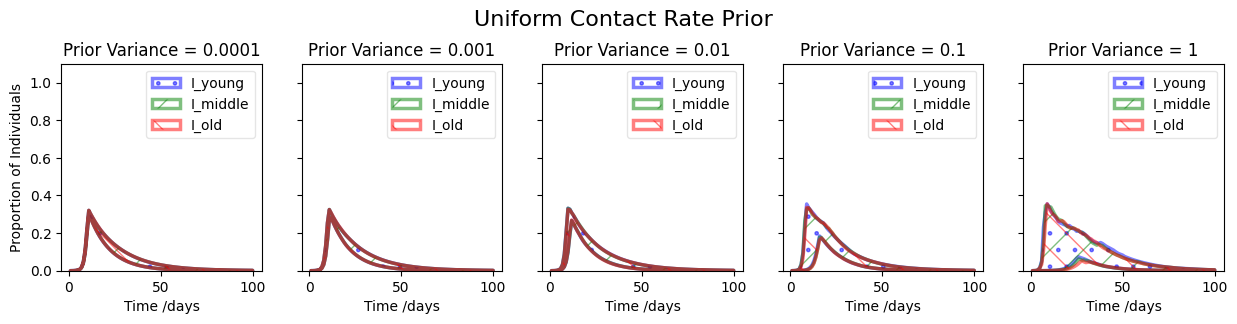

In [147]:
C_mean = torch.tensor([[1., 1., 1.], 
                        [1., 1., 1.], 
                        [1., 1., 1.]])/3

run_scenario1(C_mean, "Uniform Contact Rate Prior")

## Part ii
"Simulate this model for the case where there is significant in-group contact preference – you may choose the numbers in the matrix to represent this in-group preference."





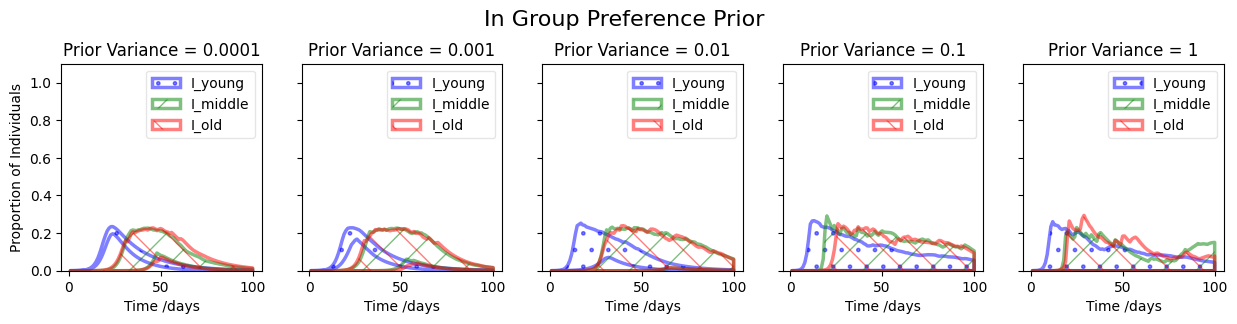

In [148]:
C_mean = torch.tensor([[1000., 1., 1.], 
                        [1., 1000., 1.], 
                        [1., 1., 1000.]])/3000

run_scenario1(C_mean, "In Group Preference Prior")

Using our CIEMSS primitives, let's again explore how these changes to model parameters influence the resulting distribution over simulation outputs.

## Part iii
"Simulate this model for the case where there is no contact between age groups. You may choose the numbers in the matrix, but ensure it meets the requirement of no contact between age groups."

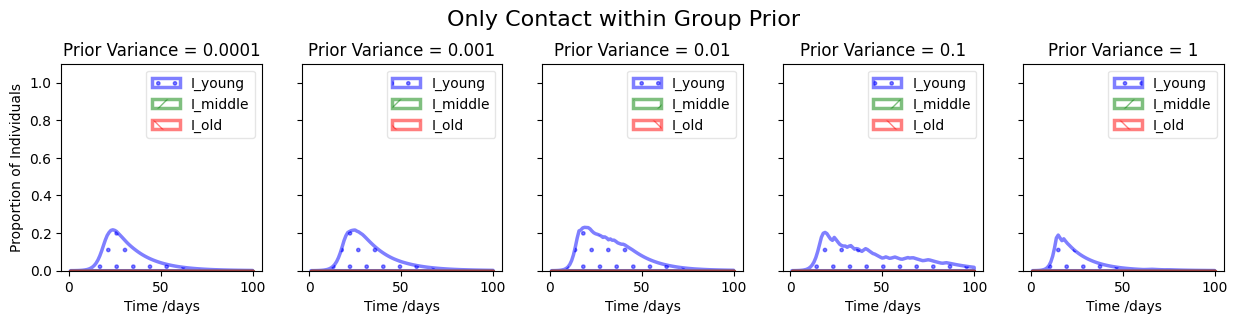

In [154]:
C_mean = torch.tensor([[1000., 0., 0.], 
                        [0., 1000., 0.], 
                        [0., 0., 1000.]])/3000

run_scenario1(C_mean, "Only Contact within Group Prior")

## Part iv
"Simulate social distancing by scaling down the uniform contact matrix by a factor (e.g. multiply by 0.5)"

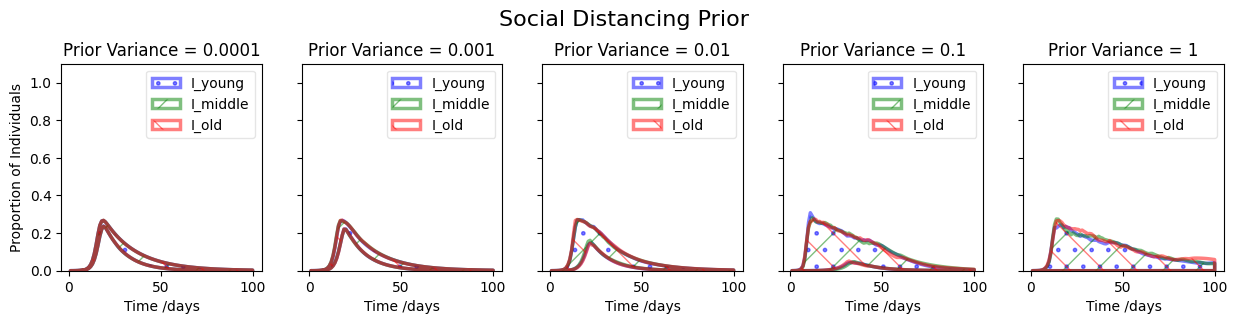

In [150]:
C_mean = torch.tensor([[1., 1., 1.], 
                        [1., 1., 1.], 
                        [1., 1., 1.]])/6

run_scenario1(C_mean, "Social Distancing Prior")

## Part v
"Repeat 1.a.iv for the scenario where the young population has poor compliance with social distancing policies, but the old population is very compliant."

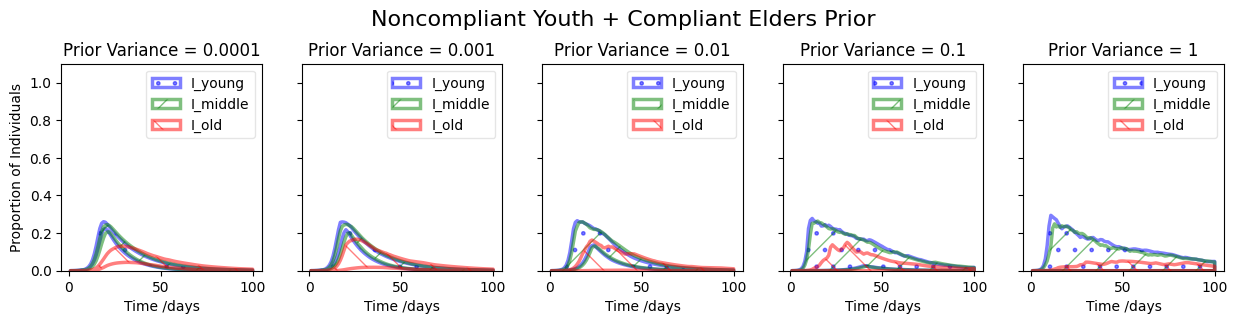

In [153]:
C_mean = torch.tensor([[2., 1., 0.1], 
                        [1., 1., 0.1], 
                        [0.1, 0.1, 0.1]])/6

run_scenario1(C_mean, "Noncompliant Youth + Compliant Elders Prior")

In [70]:
prior_prediction = sample(ode_model, num_samples, initial_state, full_tspan)
single_prediction = sample(ode_model, 1, initial_state, full_tspan)

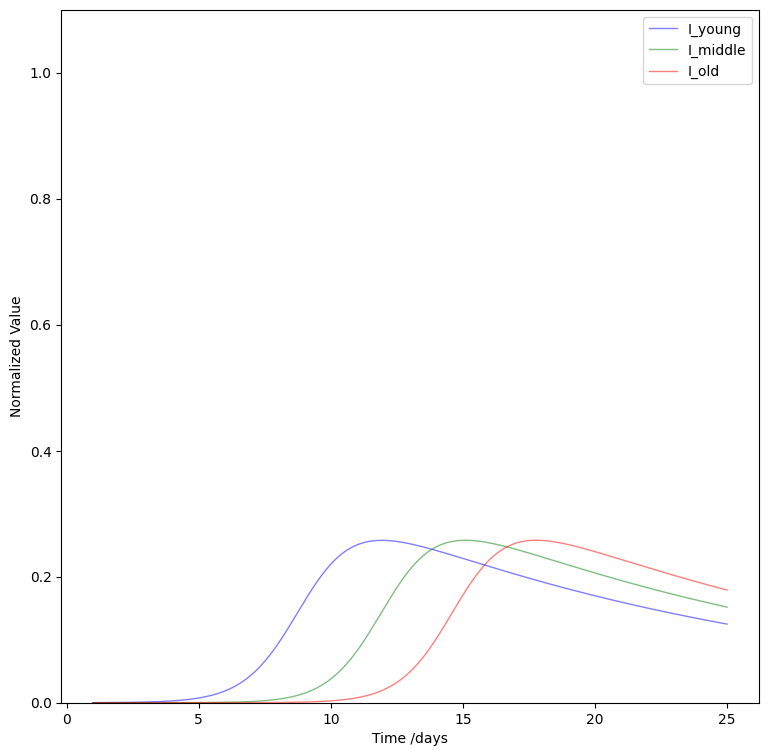

In [76]:

ax = setup_ax()

ax = plot_trajectory(single_prediction, full_tspan, plot_var="I", plot_index=0, ax=ax, color="blue", marker='', lw=1., label="I_young")
ax = plot_trajectory(single_prediction, full_tspan, plot_var="I", plot_index=1, ax=ax, color="green", marker='', lw=1., label="I_middle")
ax = plot_trajectory(single_prediction, full_tspan, plot_var="I", plot_index=2, ax=ax, color="red", marker='', lw=1., label="I_old")
ax.legend()

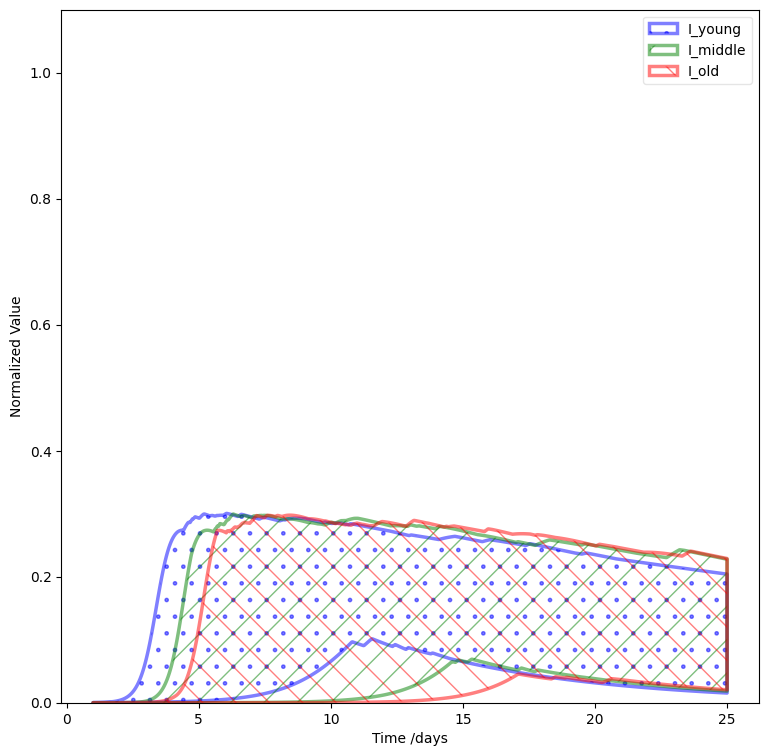

In [77]:
ax = setup_ax()

ax = plot_predictive(prior_prediction, full_tspan, plot_var="I", plot_index=0, ax=ax, label="I_young", hatch='.', edgecolor="blue", facecolor="none", linewidth=2.5, alpha=0.5)
ax = plot_predictive(prior_prediction, full_tspan, plot_var="I", plot_index=1, ax=ax, label="I_middle", hatch='/', edgecolor="green", facecolor="none", linewidth=2.5, alpha=0.5)
ax = plot_predictive(prior_prediction, full_tspan, plot_var="I", plot_index=2, ax=ax, label="I_old", hatch='\\', edgecolor="red", facecolor="none", linewidth=2.5, alpha=0.5)

# INCOMPLETE NOTEBOOK BELOW - DO NOT VENTURE DOWN!

# Probabilistic Forecasting - Exploring Possible Interventions


In [12]:

# from causal_pyro.query.do_messenger import do
from pyciemss.ODE.interventions import constant_intervention_builder, time_dependent_intervention_builder, state_dependent_intervention_builder, parameter_intervention_builder


## Q: "What would happen if we set the vaccination rate parameter, $\nu$?"


In [13]:
pyro.set_rng_seed(0)

rate_parameter_intervention = parameter_intervention_builder("nu", torch.tensor([0.01]))
# intervened_parameter_model = do(plotting_ode_model, rate_parameter_intervention)
plotting_intervened_parameter_model = intervene(plotting_ode_model, rate_parameter_intervention)
# intervened_parameter_prediction = Predictive(intervened_parameter_model, guide=guide, num_samples=num_samples)(final_observed_state, new_tspan)
intervened_parameter_prediction = sample(plotting_intervened_parameter_model, num_samples, final_observed_state, new_tspan, inferred_parameters=inferred_parameters)


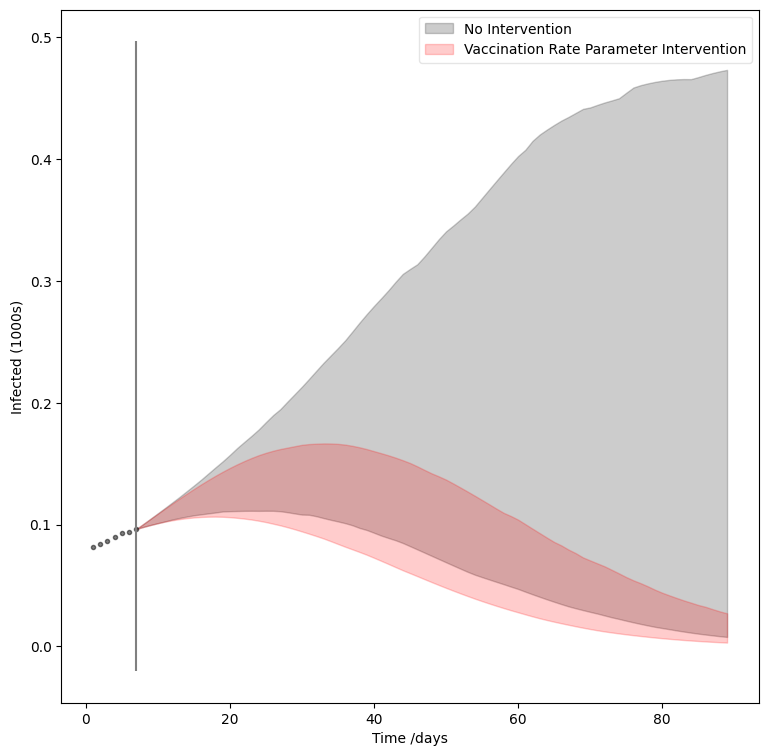

In [14]:

ax = setup_ax()
ax = plot_trajectory(data, observed_tspan, ax=ax)
ax = plot_predictive(posterior_prediction, new_tspan, tmin=7, ax=ax, label="No Intervention")
ax = plot_predictive(intervened_parameter_prediction, new_tspan, ax=ax, color='red', label="Vaccination Rate Parameter Intervention")
ax = plot_intervention_line(7., ax=ax)

## Governor: "We can't change the rate parameter directly. Bring me another policy!"
## Q: "What would happen if we set the vaccination rate to a constant 500 people per day?"

In [28]:
pyro.set_rng_seed(0)

flux_intervention = constant_intervention_builder("SV_flux", torch.tensor([500.]), full_tspan)
# intervened_flux_model = do(ode_model, flux_intervention)
plotting_intervened_flux_model = intervene(plotting_ode_model, flux_intervention)
# intervened_flux_prediction = Predictive(plotting_intervened_flux, guide=guide, num_samples=num_samples)(final_observed_state, new_tspan)
rate_intervention_prediction = sample(plotting_intervened_flux_model, num_samples, final_observed_state, new_tspan, inferred_parameters=inferred_parameters)

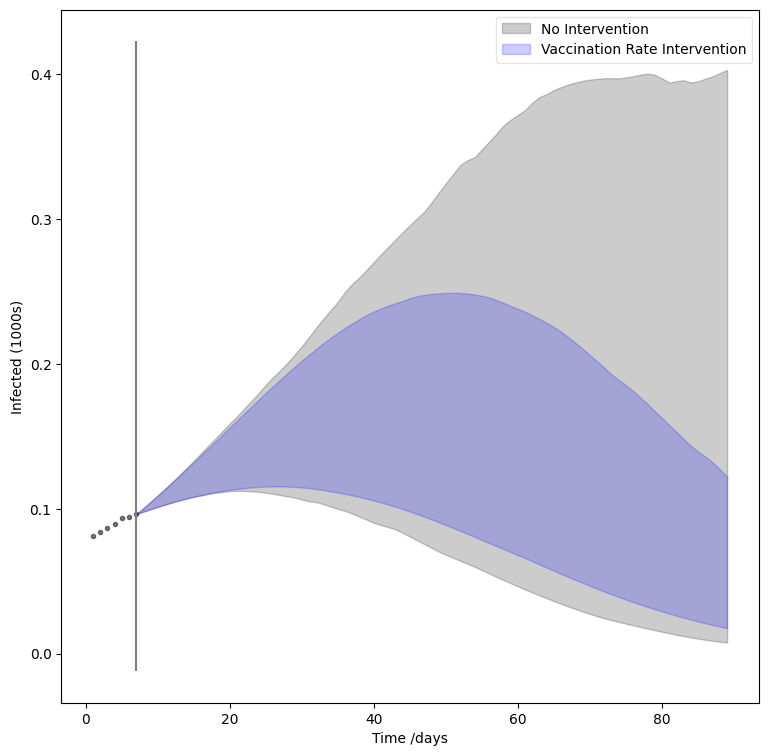

In [16]:

ax = setup_ax()
ax = plot_trajectory(data, observed_tspan, ax=ax)
ax = plot_predictive(posterior_prediction, new_tspan, ax=ax, label="No Intervention")
ax = plot_predictive(rate_intervention_prediction, new_tspan, ax=ax, color='blue', label="Vaccination Rate Intervention")
ax = plot_intervention_line(7., ax=ax)

## Governor: "We have a lot more vaccines than that, but they aren't available yet!"
## Q: "What would happen if we set the vaccination rate to 500 people per day for the first month, then 750, then 1000?"


In [18]:
pyro.set_rng_seed(0)

def ramping_rate_up_intervention_function(t):
    month = torch.floor(t / 30.).int()
    return torch.tensor([500.0, 750.0, 1000.])[month]

ramping_rate_up_intervention = time_dependent_intervention_builder("SV_flux", ramping_rate_up_intervention_function, new_tspan)
# ramping_rate_up_intervention_model = do(plotting_ode_model, ramping_rate_up_intervention)
plotting_ramping_rate_up_intervention_model = intervene(plotting_ode_model, ramping_rate_up_intervention)
# ramping_rate_up_intervention_prediction = Predictive(plotting_ramping_rate_up_intervention_model, guide=guide, num_samples=num_samples)(final_observed_state, new_tspan)
ramping_intervention_prediction = sample(plotting_ramping_rate_up_intervention_model, num_samples, final_observed_state, new_tspan, inferred_parameters=inferred_parameters)


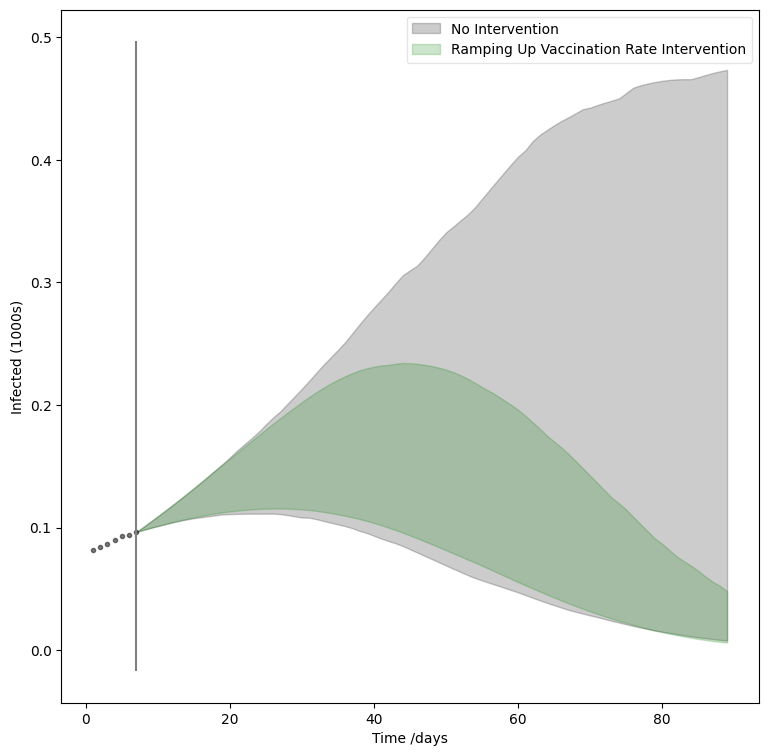

In [19]:

ax = setup_ax()
ax = plot_trajectory(data, observed_tspan, ax=ax)
ax = plot_predictive(posterior_prediction, new_tspan, ax=ax, label="No Intervention")
ax = plot_predictive(ramping_intervention_prediction, new_tspan, ax=ax, color='green', label="Ramping Up Vaccination Rate Intervention")
ax = plot_intervention_line(7., ax=ax)


## Governor: "We can't force people to take a vaccine. Let's run a marketing campaign to encourage vaccination!"
## Q: "What would happen if the marketing campaign convinces 500 **more** people per day to get vaccinated than without it?"


In [22]:
pyro.set_rng_seed(0)

def vaccination_encouragement_intervention_function(SV_flux):
    return SV_flux + torch.tensor([500.])

vaccination_encouragement_intervention = state_dependent_intervention_builder("SV_flux", vaccination_encouragement_intervention_function, new_tspan)
# plotting_vaccination_encouragement_intervention_model = do(ode_model, vaccination_encouragement_intervention)
plotting_vaccination_encouragement_intervention_model = intervene(plotting_ode_model, vaccination_encouragement_intervention)
# vaccination_encouragement_intervention_prediction = Predictive(vaccination_encouragement_intervention_model, guide=guide, num_samples=num_samples)(final_observed_state, new_tspan)
vaccination_encouragement_intervention_prediction = sample(plotting_vaccination_encouragement_intervention_model, num_samples, final_observed_state, new_tspan, inferred_parameters=inferred_parameters)


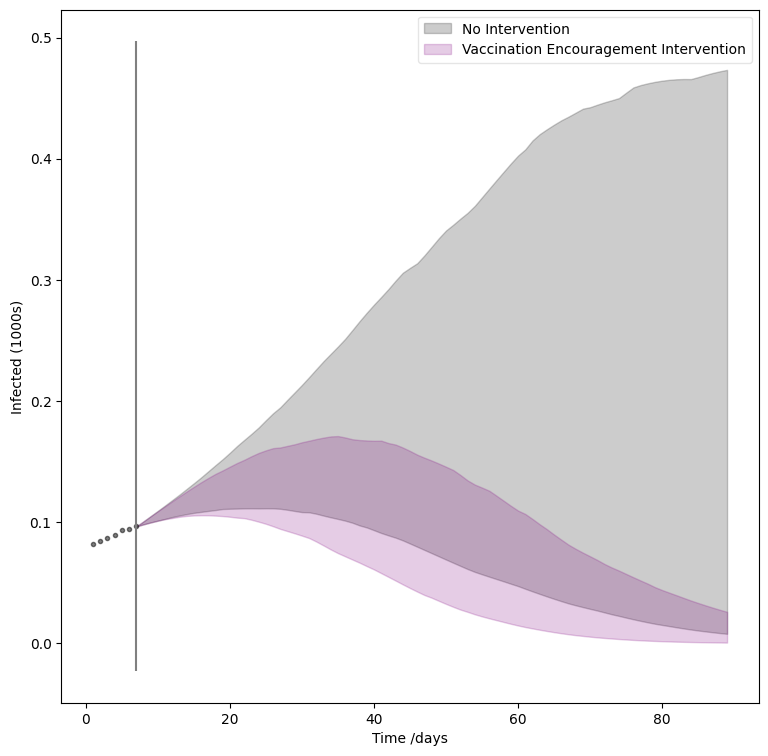

In [23]:

ax = setup_ax()
ax = plot_trajectory(data, observed_tspan, ax=ax)
ax = plot_predictive(posterior_prediction, new_tspan, ax=ax, color='black', label="No Intervention")
ax = plot_predictive(vaccination_encouragement_intervention_prediction, new_tspan, ax=ax, color='purple', label="Vaccination Encouragement Intervention")
ax = plot_intervention_line(7., ax=ax)


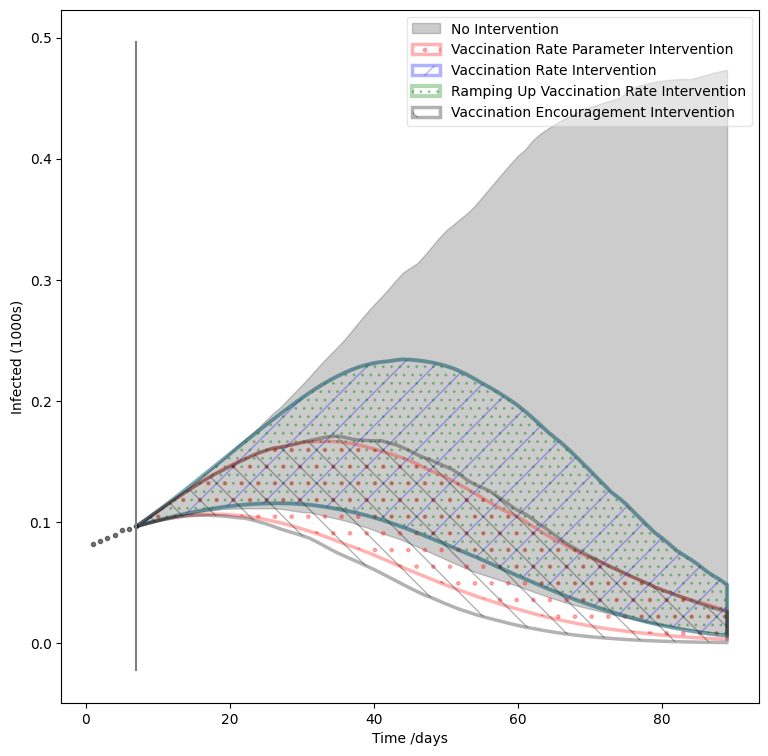

In [24]:

ax = setup_ax()
ax = plot_trajectory(data, observed_tspan, ax=ax)
ax = plot_predictive(posterior_prediction, new_tspan, color='black', ax=ax, label="No Intervention")
ax = plot_predictive(intervened_parameter_prediction, new_tspan, hatch='.', edgecolor="red", linewidth=2.5, facecolor="none", ax=ax, alpha=0.3, label="Vaccination Rate Parameter Intervention")
ax = plot_predictive(rate_intervention_prediction, new_tspan, hatch='/', ax=ax, alpha=0.3, linewidth=2.5, edgecolor='blue', facecolor="none", label="Vaccination Rate Intervention")
ax = plot_predictive(ramping_intervention_prediction, new_tspan, hatch='..', linewidth=3, ax=ax, alpha=0.3, edgecolor='green', facecolor="none", label="Ramping Up Vaccination Rate Intervention")
ax = plot_predictive(vaccination_encouragement_intervention_prediction, new_tspan, hatch="\\", linewidth=2.5, ax=ax, alpha=0.3, edgecolor='black', facecolor="none", label="Vaccination Encouragement Intervention")
ax = plot_intervention_line(7., ax=ax)


## Governor: "Let's only market to young people!"
## Q: "What would happen if the marketing campaign convinces 500 more people age 18-24 per day to get vaccinated than without it?"


In [25]:

pyro.set_rng_seed(0)

stratified_intervention = state_dependent_intervention_builder("SV_flux_18-24", vaccination_encouragement_intervention_function, new_tspan)
# stratified_intervention_model = do(ode_model, stratified_intervention)
stratified_intervention_model = intervene(ode_model, stratified_intervention)


In [24]:

import sys
ipython = get_ipython()

def hide_traceback(exc_tuple=None, filename=None, tb_offset=None,
                   exception_only=False, running_compiled_code=False):
    etype, value, tb = sys.exc_info()
    value.__cause__ = None  # suppress chained exceptions
    return ipython._showtraceback(etype, value, ipython.InteractiveTB.get_exception_only(etype, value))

ipython.showtraceback = hide_traceback

raise ValueError("The Intervention Variable SV_flux_18-24 is not defined and can not be intervened on. To fix this error, revise the model to include SV_flux_18-24").with_traceback(None) from None

ValueError: The Intervention Variable SV_flux_18-24 is not defined and can not be intervened on. To fix this error, revise the model to include SV_flux_18-24

# Risk-based optimization under uncertainty
## Q: "What is the minimal vaccination policy that results in less than 150 infected individuals after 90 days?"

### Problem Formulation
* **Quantity of interest**: 7-day average of total infections after 90 days
    $$M(\mathbf{u}, \theta) = \frac{1}{7}\sum_{i=0}^6 I(t=90-i;\mathbf{u},\theta)+I_\text{V}(t=90-i;\mathbf{u},\theta)$$

* **Control**: $\mathbf{u}\in \mathcal{U} \subseteq \mathbb{R}^{n_u}$
    * Vaccination rate parameter: $u=\nu$
    * Scheduled intervention changing SV_flux over each month: $\mathbf{u} \in \mathbb{R}^3$
    * Other practical policies as interventions



* **Risk-based optimization under uncertainty problem formulation**
    * Objective Function - Minimize the vaccination rate.
    * Constraint - Risk of infections exceeding the prescribed threshold of 10, $\mathcal{R}( M(\mathbf{u}, \theta))$, is below the acceptable risk threshold, $\mathcal{R}_\text{threshold}$.

\begin{equation} 
\begin{split} 
\mathbf{u}^*= \underset{\mathbf{u}\in\mathcal{U}}{\arg\min}\ & \lVert \mathbf{u} \rVert_1 \\ \text{s.t.}\ & \mathcal{R}( M(\mathbf{u}, \theta)) \le \mathcal{R}_\text{threshold} 
\end{split} 
\end{equation}

## Comparing risk measures

![table_risk.png](figures/table_risk.png)

#### Adavantages of using alpha-superquantile
* Considers magnitude of infections exceeding the threshold:
    * Overcome limitations of hard thresholding
    * Desirable data-informed conservativeness
* Preserves properties of underlying quantities of interest, such as convexity

In [25]:
import os
import time
import pickle

import sys
sys.path.append("../")

import numpy as np
from scipy import stats
from matplotlib import ticker

from pyciemss.ODE.models import SVIIvR
from pyciemss.ODE.interventions import constant_intervention_builder

from pyciemss.risk.risk_measures import alpha_quantile, alpha_superquantile
from pyciemss.risk.ouu import computeRisk
from pyciemss.risk.qoi import nday_rolling_average

# Plotting helpers
def sideaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return

def sideaxishist(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # For y-axis
    ax.yaxis.set_major_locator(ticker.NullLocator())
    ax.tick_params(axis='x', labelsize=12)  # change fontsize for x-axis tick labels
    # ax.xaxis.major.formatter._useMathText = True
    return


co = ['#377eb8', '#ff7f00', '#984ea3', '#ffd92f', '#a65628']
rlabel = ['Q_alpha-based OUU', 'barQ_alpha-based OUU']

## Exploring the difference between Quantiles and Super-Quantiles

In [26]:
torch.manual_seed(1)

POLICY = np.array([100.])
N_SAMPLES = 1000

RISK = computeRisk(model=ode_model,
                 intervention_fun=lambda x: constant_intervention_builder("SV_flux", torch.from_numpy(x), new_tspan),
                 qoi=lambda y: nday_rolling_average(y, contexts=["I_obs"]),
                 risk_measure=alpha_superquantile,
                 num_samples=N_SAMPLES,
                 model_state=final_observed_state,
                 tspan=new_tspan,
                 guide=guide
                )

start_time = time.time()
sq_dataCube = RISK.propagate_uncertainty(POLICY)
end_time = time.time()
forward_time = end_time - start_time
time_per_eval = forward_time / N_SAMPLES
print(f"Forward UQ took {forward_time:.2f} seconds total ({forward_time/N_SAMPLES:.2e} seconds per model evaluation).")
sq_qoi = RISK.qoi(sq_dataCube)
sq_sv = RISK.risk_measure(sq_qoi)

RISK.risk_measure = alpha_quantile
q_sv = RISK(POLICY)

Forward UQ took 40.57 seconds total (4.06e-02 seconds per model evaluation).


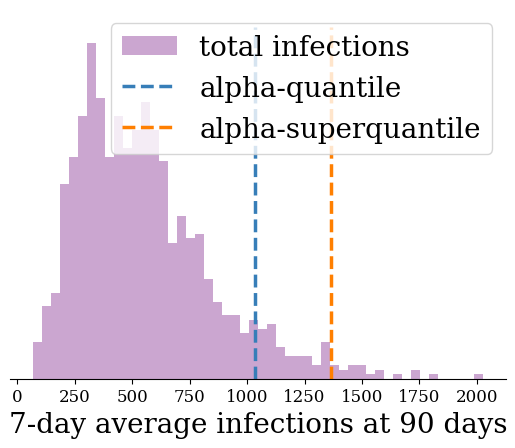

In [27]:
bins_hist = 50
fig1 = plt.figure()
plt.rc('text', usetex=False)
plt.rc('font', family='serif', size=18.)
cax = plt.gca()
sideaxishist(cax)
cax.hist(sq_qoi, color=co[2], bins=bins_hist, histtype='stepfilled', alpha=0.5, label='total infections')
miny = min(cax.get_ylim())
maxy = max(cax.get_ylim())
cax.vlines(q_sv, miny, maxy, linestyle='--', linewidth=2.5, label='alpha-quantile', color=co[0])
cax.vlines(sq_sv, miny, maxy, linestyle='--', linewidth=2.5, label='alpha-superquantile', color=co[1])
cax.set_xlabel('7-day average infections at 90 days', size=20)
cax.legend(loc='upper right', prop={'size': 20})
plt.show()

## Risk-based optimization under uncertainty with intervention on vaccination rate parameter $\nu$
**NOTE:** This is a demonstration of the interface, optimization is not run to convergence nor are enough samples generated to accurately estimate the risk, so take the results with a grain of salt.

In [28]:
from pyciemss.risk.ouu import RandomDisplacementBounds, computeRisk, solveOUU
from pyciemss.risk.qoi import nday_rolling_average
from pyciemss.risk.risk_measures import alpha_superquantile, alpha_quantile
import scipy

# Define problem specifics.
RISK_BOUND = 250.
X_MIN = 0.
X_MAX = 0.95

N_SAMPLES = int(5e2)
MAXITER = 10
TOL = 1e-5

RISK_ALPHA = 0.9

# Control action / intervention.
INIT_ITERATE = 0.75
INTERVENTION = lambda x: constant_intervention_builder("nu", x, new_tspan)

# Objective function.
OBJFUN = lambda x: x  # minimize the scalar value itself.

# Define the risk measure.
VAX_RISK = computeRisk(
                        model=noisy_ode_model,
                        intervention_fun=INTERVENTION,
                        qoi=lambda y: nday_rolling_average(y, contexts=["I_obs"]),
                        model_state=final_observed_state,
                        tspan=new_tspan,
                        risk_measure=lambda z: alpha_superquantile(z, alpha=RISK_ALPHA),
                        num_samples=N_SAMPLES,
                        guide=guide,
                        )

# Define problem constraints.
CONSTRAINTS = (
                # risk constraint
                {'type': 'ineq', 'fun': lambda x: RISK_BOUND - VAX_RISK(x)},

                # bounds on control
                # NOTE: perhaps use scipy.optimize.LinearConstraint in the future
                {'type': 'ineq', 'fun': lambda x: x - X_MIN},
                {'type': 'ineq', 'fun': lambda x: X_MAX - x}
               )

In [29]:
# Go do the dang thing.
print("Performing risk-based optimization under uncertainty ...")
print(f"Estimated wait time {time_per_eval*N_SAMPLES*MAXITER:.0f} seconds.")
sq_result = solveOUU(
                     x0=INIT_ITERATE,
                     objfun=OBJFUN,
                     constraints=CONSTRAINTS,
                     optimizer_algorithm="COBYLA",
                     tol=TOL,
                     options={
                         "disp": False,
                         "maxiter": MAXITER
                             },
                    ).solve()
print(f"Optimizer finished. Optimal Vaccination rate is:\t{sq_result.x[0]:.4}")
est_risk = VAX_RISK(sq_result.x[0])
print(f"Estimated risk was:\t{est_risk:.2f}")

Performing risk-based optimization under uncertainty ...
Estimated wait time 203 seconds.
Optimizer finished. Optimal Vaccination rate is:	1.75
Estimated risk was:	496.06


## Assess the effect of the control policy.

In [30]:
intervened_prediction = VAX_RISK.propagate_uncertainty(POLICY)
qois = VAX_RISK.qoi(intervened_prediction)

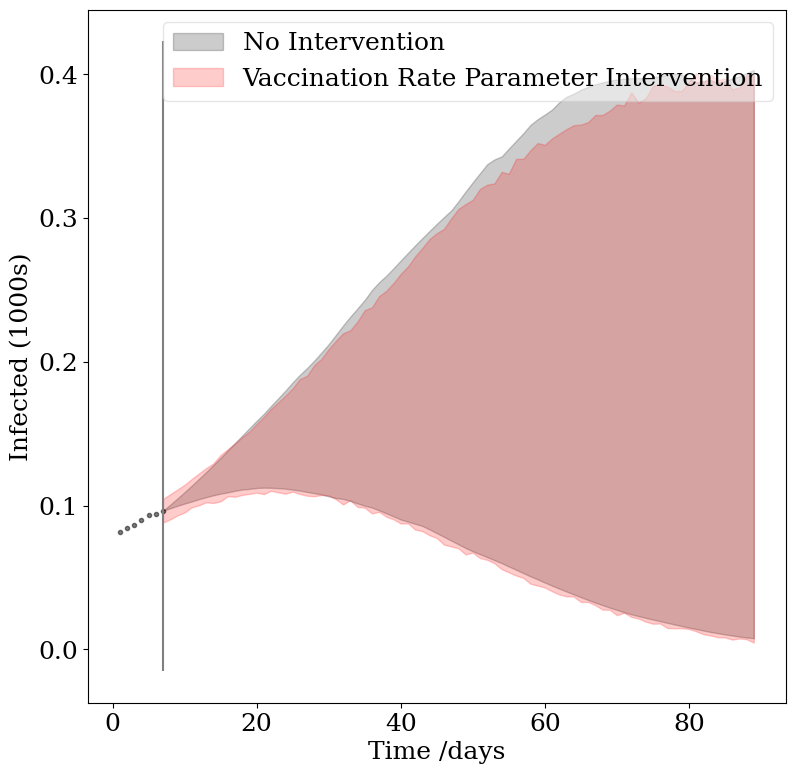

In [31]:

ax = setup_ax()
ax = plot_trajectory(data, observed_tspan, ax=ax)
ax = plot_predictive(posterior_prediction, new_tspan, tmin=7, ax=ax, label="No Intervention")
ax = plot_predictive(intervened_prediction, new_tspan, ax=ax, color='red', label="Vaccination Rate Parameter Intervention")
ax = plot_intervention_line(7., ax=ax)


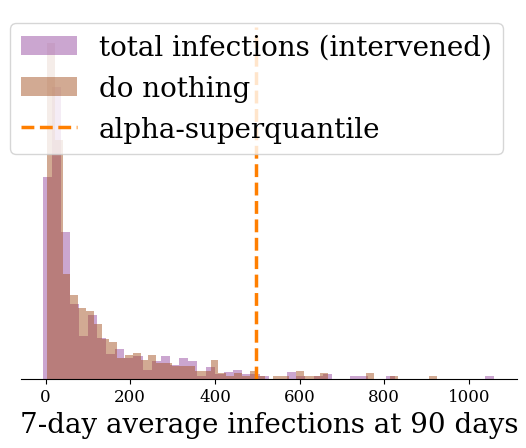

In [32]:
bins_hist = 50
fig1 = plt.figure()
# plt.rc('text')
plt.rc('font', family='serif', size=18.)
cax = plt.gca()
sideaxishist(cax)
cax.hist(qois, color=co[2], bins=bins_hist, histtype='stepfilled', alpha=0.5, label='total infections (intervened)', density=True)
cax.hist(VAX_RISK.qoi(posterior_prediction), color=co[4], bins=bins_hist, histtype='stepfilled', alpha=0.5, label='do nothing', density=True)
miny = min(cax.get_ylim())
maxy = max(cax.get_ylim())
cax.vlines(est_risk, miny, maxy, linestyle='--', linewidth=2.5, label='alpha-superquantile', color=co[1])
cax.set_xlabel('7-day average infections at 90 days', size=20)
cax.legend(loc='upper right', prop={'size': 20})
plt.show()